#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 11
**CH11A Does Smoking Pose a Health Risk?**

using the share-health dataset

version 1.0 2021-05-05

In [1]:
import os
from pathlib import Path
import sys
import warnings

import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from plotnine import *
from scipy.stats import logistic
from scipy.stats import norm
from stargazer.stargazer import Stargazer
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import log_loss

warnings.filterwarnings("ignore")


In [2]:
path = Path(os.getcwd())

base_dir = path.parent.parent

data_in = os.path.join(str(base_dir), "da_data_repo/share-health/clean/")
data_out = os.path.join(str(base_dir), "da_case_studies/ch11-smoking-health-risk/")
output = os.path.join(str(base_dir), "da_case_studies/ch12-stock-returns-risk/output/")
func = os.path.join(str(base_dir), "da_case_studies/ch00-tech-prep/")


In [3]:
sys.path.append(func)

from py_helper_functions import *


In [4]:
share = pd.read_csv(os.path.join(data_in, "share-health.csv"))
# share = pd.read_csv("https://osf.io/download/snfhe/")

# Part I – create workfile

In [5]:
share["healthy"] = 0
share.loc[(share["sphus"] == 1) | (share["sphus"] == 2), "healthy"] = 1
share.loc[~((share["sphus"] > 0) & (share["sphus"] <= 5)), "healthy"] = np.nan


In [6]:
share["healthy"].value_counts()


0.0    213847
1.0     73808
Name: healthy, dtype: int64

In [7]:
share = share.dropna(how="any")


In [8]:
share["baseline"] = 0
share.loc[share["wave"] == 4, "baseline"] = 1
share["endline"] = 0
share.loc[share["wave"] == 6, "endline"] = 1


In [9]:
share["baseline"].value_counts()


0    229773
1     57882
Name: baseline, dtype: int64

In [10]:
share["endline"].value_counts()


0    219568
1     68087
Name: endline, dtype: int64

In [11]:
share["temp"] = np.where(
    share["endline"] == 1, np.where(share["healthy"] == 1, 1, 0), np.nan
)


In [12]:
share["temp"].value_counts()


0.0    51241
1.0    16846
Name: temp, dtype: int64

In [13]:
share["stayshealthy"] = share.groupby("mergeid")["temp"].transform(np.nanmax)


In [14]:
share["stayshealthy"].value_counts()


0.0    148453
1.0     46718
Name: stayshealthy, dtype: int64

In [15]:
share = share.drop("temp", axis=1)


In [16]:
# keep if endline health outcome non-missing
share = share.loc[lambda x: (x["stayshealthy"] == 1) | (x["stayshealthy"] == 0)]


In [17]:
# keep baseline observations (endline outcome already defined for them)
share = share.loc[lambda x: x["baseline"] == 1]


In [18]:
# keep age 50-60 at baseline
share = share.loc[lambda x: (x["age"] >= 50) & (x["age"] <= 60)]


In [19]:
# keep healthy individuals at baseline
share = share.loc[lambda x: x["healthy"] == 1]


In [20]:
# keep those with non-missing observations for smoking at baseline
# and re-define smoking to be 0-1
share.loc[lambda x: x["smoking"] == 5, "smoking"] = 0
share = share.loc[lambda x: (x["smoking"] == 0) | (x["smoking"] == 1)]

share.loc[lambda x: x["ever_smoked"] == 5, "ever_smoked"] = 0
share = share.loc[lambda x: (x["ever_smoked"] == 0) | (x["ever_smoked"] == 1)]


In [21]:
share["exerc"] = np.where(
    share["br015"] == 1,
    1,
    np.where((share["br015"] > 0) & (share["br015"] != 1), 0, np.nan),
)
share["exerc"].value_counts()


1.0    1702
0.0    1569
Name: exerc, dtype: int64

In [22]:
share["bmi"] = np.where(share["bmi"] < 0, np.nan, share["bmi"])

share["bmi"].describe().round(2)


count    3197.00
mean       25.54
std         3.90
min        16.33
25%        22.84
50%        25.10
75%        27.77
max        45.63
Name: bmi, dtype: float64

In [23]:
share = share.rename(columns={"income_pct_w4": "income10"})


In [24]:
share["married"] = np.where((share["mar_stat"] == 1) | (share["mar_stat"] == 2), 1, 0)


In [25]:
share["eduyears"] = np.where(share["eduyears_mod"] < 0, np.nan, share["eduyears_mod"])

share["eduyears"].describe().round(2)


count    3184.00
mean       12.31
std         4.57
min         0.00
25%        10.00
50%        12.00
75%        16.00
max        25.00
Name: eduyears, dtype: float64

In [26]:
share = share.drop("eduyears_mod", axis=1)


In [27]:
share = share.loc[
    lambda x: (x["bmi"].notnull()) & (x["eduyears"].notnull()) & (x["exerc"].notnull())
]


In [28]:
share.filter(
    [
        "stayshealthy",
        "smoking",
        "ever_smoked",
        "female",
        "age",
        "income10",
        "eduyears",
        "bmi",
        "exerc",
    ]
).describe().round(2)


,stayshealthy,smoking,ever_smoked,female,age,income10,eduyears,bmi,exerc
count,3109.00,3109.00,3109.00,3109.00,3109.00,3109.00,3109.00,3109.00,3109.00
mean,0.60,0.22,0.49,0.56,55.19,6.79,12.33,25.53,0.52
std,0.49,0.42,0.50,0.50,2.79,2.75,4.56,3.91,0.50
min,0.00,0.00,0.00,0.00,50.00,1.00,0.00,16.33,0.00
25%,0.00,0.00,0.00,0.00,52.80,5.00,10.00,22.84,0.00
50%,1.00,0.00,0.00,1.00,55.30,7.00,13.00,25.10,1.00
75%,1.00,0.00,1.00,1.00,57.50,9.00,16.00,27.77,1.00
max,1.00,1.00,1.00,1.00,60.00,10.00,25.00,45.63,1.00


In [29]:
pd.crosstab(share["country"], share["stayshealthy"])


stayshealthy,0.0,1.0
country,,
11,118,254
12,21,24
13,25,55
15,82,92
16,123,86
17,135,166
18,73,322
20,131,309
23,173,265


In [30]:
share.reset_index(drop=True).to_csv("ch11_share.csv")


#  2. PART - SIMPLE LPM MODELS

In [31]:
share = pd.read_csv("ch11_share.csv", index_col=0)


In [32]:
share.head()


,mergeid,wave,country,country_mod,int_year,int_month,female,age,sphus,br015,...,income10,bmi,mar_stat,healthy,baseline,endline,stayshealthy,exerc,married,eduyears
0,AT-001492-02,4,11,40,2011,9,0,59.799999,2,3,...,8,23.198315,1,1.0,1,0,1.0,0.0,1,13.0
1,AT-002136-03,4,11,40,2011,8,1,58.200001,1,2,...,9,24.801588,1,1.0,1,0,1.0,0.0,1,14.0
2,AT-002800-01,4,11,40,2011,9,1,57.000000,2,4,...,3,22.038567,3,1.0,1,0,1.0,0.0,0,23.0
3,AT-009262-02,4,11,40,2011,12,0,59.299999,2,1,...,6,25.826447,1,1.0,1,0,0.0,1.0,1,12.0
4,AT-009376-01,4,11,40,2011,9,0,53.299999,2,1,...,8,26.827421,1,1.0,1,0,0.0,1.0,1,3.0


In [33]:
lpm1 = smf.ols("stayshealthy ~ smoking", data=share).fit(cov_type="HC1")


In [34]:
lpm2 = smf.ols("stayshealthy ~ smoking + ever_smoked", data=share).fit(covtype="HC1")


### Table 11.1 Probability of staying healthy

In [35]:
stargazer = Stargazer([lpm1, lpm2])
stargazer.covariate_order(["smoking", "ever_smoked", "Intercept"])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer


In [36]:
share["pred1"] = lpm1.predict()

pd.crosstab(index=share["pred1"], columns=share["smoking"])


smoking,0,1
pred1,,
0.550287,0,696
0.620390,2413,0


In [37]:
pd.crosstab(index=share["stayshealthy"], columns=share["smoking"])


smoking,0,1
stayshealthy,,
0.0,916,313
1.0,1497,383


In [38]:
share["weight"] = share.groupby(["smoking", "stayshealthy"])["smoking"].transform(len)
share["weight_2"] = share["weight"] / 1000


### Figure 11.1 Staying healthy and smoking – scatterplot and regression line

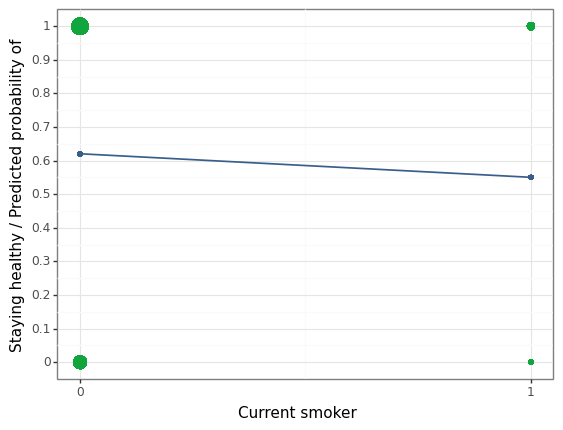

<ggplot: (674701975)>

In [39]:
g1 = (
    ggplot(data=share)
    + geom_point(aes(x="smoking", y="pred1"), size=1, color=color[0])
    + geom_line(aes(x="smoking", y="pred1"), colour=color[0], size=0.7)
    + geom_point(
        aes(x="smoking", y="stayshealthy", size="weight_2"),
        fill=color[1],
        color=color[1],
        alpha=0.8,
        show_legend=False,
    )
    + labs(x="Current smoker", y="Staying healthy / Predicted probability of ")
    + coord_cartesian(xlim=[0, 1], ylim=[0, 1])
    + scale_y_continuous(limits=[0, 1], breaks=seq(0, 1, 0.1))
    + scale_x_continuous(limits=[0, 1], breaks=seq(0, 1, 1))
    + theme_bw()
)
g1

In [40]:
share["weight"] = (
    share.groupby(["eduyears", "stayshealthy"])["smoking"].transform(len) / 100
)


### Figure 11.2 Education, income, and the probability of staying healthy – non-parametric regressions

(a) Staying healthy and years of education

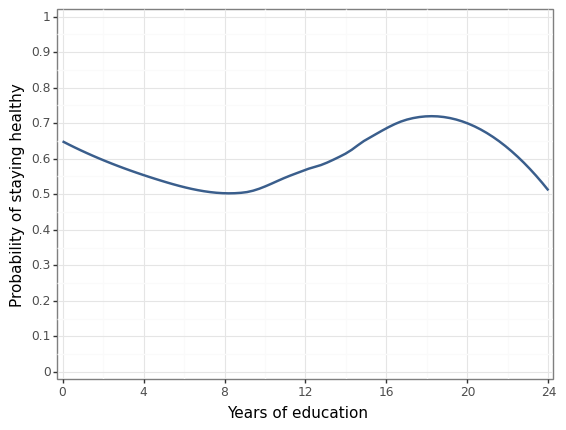

<ggplot: (674833710)>

In [41]:
g2 = (
    ggplot(data=share)
    + geom_smooth(
        aes(x="eduyears", y="stayshealthy"), method="loess", se=False, color=color[0]
    )
    + labs(x="Years of education", y="Probability of staying healthy ")
    # + coord_cartesian(xlim = [0, 1], ylim=[0,1])
    + scale_x_continuous(expand=[0.01, 0.01], limits=[0, 24], breaks=seq(0, 24, 4))
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=seq(0, 1, 0.1))
    + theme_bw()
)
g2


(b) Staying healthy and income group

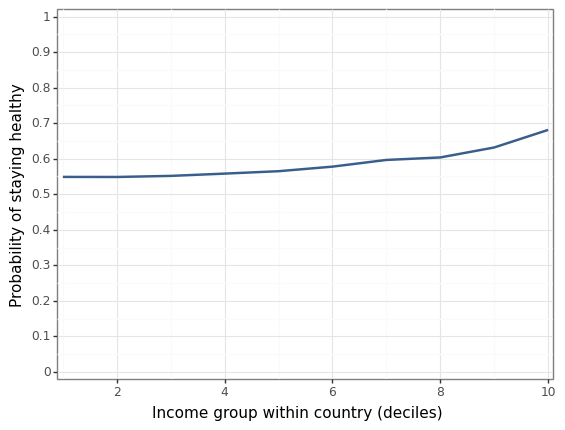

<ggplot: (674812103)>

In [42]:
g2b = (
    ggplot(data=share)
    + geom_smooth(
        aes(x="income10", y="stayshealthy"), method="loess", se=False, color=color[0]
    )
    + labs(
        x="Income group within country (deciles)", y="Probability of staying healthy "
    )
    + scale_x_continuous(expand=[0.01, 0.01], limits=[1, 10], breaks=seq(0, 10, 2))
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=seq(0, 1, 0.1))
    + theme_bw()
)
g2b


Not in the book

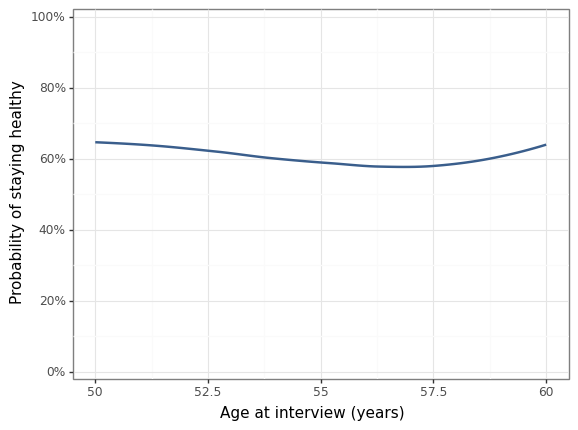

<ggplot: (674797093)>

In [43]:
g2c = (
    ggplot(data=share)
    + geom_smooth(
        aes(x="age", y="stayshealthy"), method="loess", se=False, color=color[0]
    )
    + scale_y_continuous(
        expand=[0.01, 0.01],
        limits=[0, 1],
        breaks=seq(0, 1, 0.2),
        labels=percent_format(),
    )
    + labs(x="Age at interview (years)", y="Probability of staying healthy")
    + theme_bw()
)
g2c


Not in the book

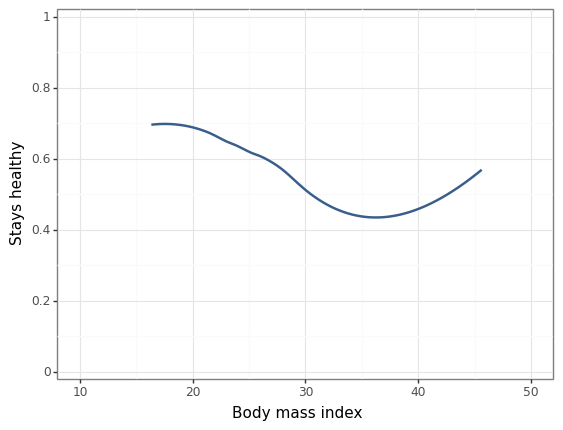

<ggplot: (674666301)>

In [44]:
g2d = (
    ggplot(data=share)
    + geom_smooth(
        aes(x="bmi", y="stayshealthy"), method="loess", se=False, color=color[0]
    )
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=seq(0, 1, 0.2))
    + scale_x_continuous(limits=[10, 50], breaks=seq(10, 50, 10))
    + labs(x="Body mass index", y="Stays healthy")
    + theme_bw()
)
g2d


# 3. PART - PROBABILITY MODELS (LPM, LOGIT, PROBIT) & PREDICTION

In [45]:
share["country"] = share["country"].astype("category")


In [46]:
lpm3 = smf.ols(
    "stayshealthy ~ smoking + ever_smoked + female + age + lspline(eduyears,[8,18]) + \
                    income10 + lspline(bmi,[35]) + exerc + country",
    share,
).fit(covtype="HC1")


### Table 11.2 Smoking and the probability of staying healthy – rich LPM

In [47]:
stargazer = Stargazer([lpm3])
stargazer.covariate_order(
    [
        "smoking",
        "ever_smoked",
        "female",
        "age",
        "lspline(eduyears, [8, 18])[0]",
        "lspline(eduyears, [8, 18])[1]",
        "lspline(eduyears, [8, 18])[2]",
        "income10",
        "lspline(bmi, [35])[0]",
        "lspline(bmi, [35])[1]",
        "exerc",
    ]
)
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer.add_line("Country indicators", ["Yes"])
stargazer


In [48]:
share["pred_lpm"] = lpm3.predict()


In [49]:
share["pred_lpm"].describe().round(4)


count    3109.0000
mean        0.6047
std         0.1567
min         0.0361
25%         0.5001
50%         0.6073
75%         0.7134
max         1.0110
Name: pred_lpm, dtype: float64

### Figure 11.3 Histogram of the predicted probabilities

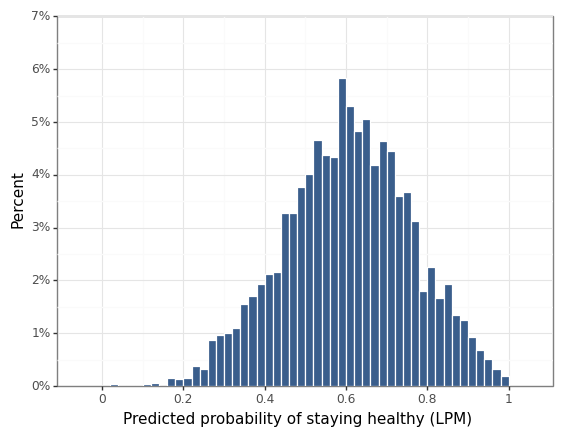

<ggplot: (674524471)>

In [50]:
g3 = (
    ggplot(share, aes(x="pred_lpm"))
    + geom_histogram(
        aes(y="stat(count)/sum(stat(count))"),
        binwidth=0.02,
        center=0.65,
        color="white",
        fill=color[0],
        closed="right",
    )
    + labs(x="Predicted probability of staying healthy (LPM)", y="Percent")
    + scale_y_continuous(
        expand=[0.00, 0.0],
        limits=[0, 0.07],
        breaks=seq(0, 0.07, 0.01),
        labels=percent_format(),
    )
    + scale_x_continuous(expand=[0.1, 0.01], limits=[0, 1], breaks=seq(0, 1, 0.2))
    + theme_bw()
)
g3


In [51]:
cuts = 100
share["q100_pred_lpm"] = pd.qcut(share["pred_lpm"], q=cuts, labels=range(1, cuts + 1))


In [52]:
share.loc[
    share["q100_pred_lpm"] == 1,
    ["smoking", "ever_smoked", "female", "age", "eduyears", "income10", "bmi", "exerc"],
].describe().round(1)

# Bottom 1%


,smoking,ever_smoked,female,age,eduyears,income10,bmi,exerc
count,32.0,32.0,32.0,32.0,32.0,32.0,32.0,32.0
mean,0.4,0.5,0.4,56.0,7.7,3.8,30.5,0.2
std,0.5,0.5,0.5,2.6,3.3,2.8,3.9,0.4
min,0.0,0.0,0.0,50.4,0.0,1.0,23.0,0.0
25%,0.0,0.0,0.0,53.9,4.8,1.0,28.1,0.0
50%,0.0,0.0,0.0,56.5,8.0,3.0,30.5,0.0
75%,1.0,1.0,1.0,57.8,10.2,6.2,33.9,0.0
max,1.0,1.0,1.0,59.9,14.0,10.0,38.1,1.0


In [53]:
share.loc[
    share["q100_pred_lpm"] == 100,
    ["smoking", "ever_smoked", "female", "age", "eduyears", "income10", "bmi", "exerc"],
].describe().round(1)

# Top 1%


,smoking,ever_smoked,female,age,eduyears,income10,bmi,exerc
count,32.0,32.0,32.0,32.0,32.0,32.0,32.0,32.0
mean,0.0,0.4,1.0,53.9,17.3,8.9,20.8,0.9
std,0.0,0.5,0.2,2.5,1.5,1.6,1.8,0.3
min,0.0,0.0,0.0,50.6,13.0,4.0,17.2,0.0
25%,0.0,0.0,1.0,52.1,16.0,8.8,19.7,1.0
50%,0.0,0.0,1.0,53.4,17.5,10.0,20.8,1.0
75%,0.0,1.0,1.0,55.2,18.0,10.0,22.1,1.0
max,0.0,1.0,1.0,60.0,20.0,10.0,24.5,1.0


# 4. PART - LOGIT VS. PROBIT MODELS

In [54]:
y, X = dmatrices(
    "stayshealthy ~ smoking + ever_smoked + female + age + lspline(eduyears,[8,18]) + \
                 income10 + lspline(bmi,[35]) + exerc + country",
    share,
)

logit = sm.GLM(y, X, family=sm.families.Binomial(link=sm.genmod.families.links.logit()))
logit = logit.fit()


In [55]:
logit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           stayshealthy   No. Observations:                 3109
Model:                            GLM   Df Residuals:                     3084
Model Family:                Binomial   Df Model:                           24
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1918.8
Date:                Thu, 06 Oct 2022   Deviance:                       3837.5
Time:                        15:48:14   Pearson chi2:                 3.12e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1022
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         2.2781      0.885      2.573      0.010       0.543       4.013
country[T.12]                    -0.9828      0.330     -2.978      0.003      -1.630      -0.336
country[T.13]                    -0.1972      0.276     -0.714      0.475      -0.739       0.344
country[T.15]                    -0.6560      0.194     -3.382      0.001      -1.036      -0.276
country[T.16]                    -1.1196      0.185     -6.051      0.000      -1.482      -0.757
country[T.17]                    -0.7850      0.169     -4.640      0.000      -1.116      -0.453
country[T.18]                     0.4358      0.181      2.411      0.016       0.082       0.790
country[T.20]                     0.0679      0.159      0.426      0.670      -0.244       0.380
country[T.23]                    -0.5734      0.157     -3.650      0.000      -0.881      -0.265
country[T.28]                    -0.7552      0.176     -4.297      0.000      -1.100      -0.411
country[T.29]                    -1.4707      0.395     -3.719      0.000      -2.246      -0.696
country[T.33]                    -1.5783      0.301     -5.243      0.000      -2.168      -0.988
country[T.34]                    -0.9203      0.205     -4.482      0.000      -1.323      -0.518
country[T.35]                    -1.3535      0.211     -6.416      0.000      -1.767      -0.940
smoking                          -0.2840      0.109     -2.601      0.009      -0.498      -0.070
ever_smoked                       0.0782      0.092      0.849      0.396      -0.102       0.259
female                            0.1608      0.082      1.964      0.050       0.000       0.321
age                              -0.0123      0.014     -0.859      0.391      -0.040       0.016
lspline(eduyears, [8, 18])[0]    -0.0030      0.033     -0.090      0.928      -0.068       0.062
lspline(eduyears, [8, 18])[1]     0.0791      0.016      5.022      0.000       0.048       0.110
lspline(eduyears, [8, 18])[2]    -0.0457      0.055     -0.825      0.410      -0.154       0.063
income10                          0.0356      0.015      2.452      0.014       0.007       0.064
lspline(bmi, [35])[0]            -0.0575      0.011     -5.033      0.000      -0.080      -0.035
lspline(bmi, [35])[1]             0.0311      0.071      0.439      0.661      -0.108       0.170
exerc                             0.2548      0.079      3.229      0.001       0.100       0.410
=================================================================================================
"""

In [56]:
share["pred_logit"] = logit.predict()


In [57]:
share["pred_logit"].describe()


count    3109.000000
mean        0.604696
std         0.157277
min         0.107760
25%         0.496971
50%         0.614335
75%         0.723092
max         0.920142
Name: pred_logit, dtype: float64

In [58]:
logit = sm.Logit(y, X)


In [59]:
logit_result = logit.fit()


Optimization terminated successfully.
         Current function value: 0.617166
         Iterations 5


In [60]:
logit_result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           stayshealthy   No. Observations:                 3109
Model:                          Logit   Df Residuals:                     3084
Method:                           MLE   Df Model:                           24
Date:                Thu, 06 Oct 2022   Pseudo R-squ.:                 0.08031
Time:                        15:48:14   Log-Likelihood:                -1918.8
converged:                       True   LL-Null:                       -2086.3
Covariance Type:            nonrobust   LLR p-value:                 1.329e-56
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         2.2781      0.885      2.573      0.010       0.543       4.013
country[T.12]                    -0.9828      0.330     -2.978      0.003      -1.630      -0.336
country[T.13]                    -0.1972      0.276     -0.714      0.475      -0.739       0.344
country[T.15]                    -0.6560      0.194     -3.382      0.001      -1.036      -0.276
country[T.16]                    -1.1196      0.185     -6.051      0.000      -1.482      -0.757
country[T.17]                    -0.7850      0.169     -4.640      0.000      -1.116      -0.453
country[T.18]                     0.4358      0.181      2.411      0.016       0.082       0.790
country[T.20]                     0.0679      0.159      0.426      0.670      -0.244       0.380
country[T.23]                    -0.5734      0.157     -3.650      0.000      -0.881      -0.265
country[T.28]                    -0.7552      0.176     -4.297      0.000      -1.100      -0.411
country[T.29]                    -1.4707      0.395     -3.719      0.000      -2.246      -0.696
country[T.33]                    -1.5783      0.301     -5.243      0.000      -2.168      -0.988
country[T.34]                    -0.9203      0.205     -4.482      0.000      -1.323      -0.518
country[T.35]                    -1.3535      0.211     -6.416      0.000      -1.767      -0.940
smoking                          -0.2840      0.109     -2.601      0.009      -0.498      -0.070
ever_smoked                       0.0782      0.092      0.849      0.396      -0.102       0.259
female                            0.1608      0.082      1.964      0.050       0.000       0.321
age                              -0.0123      0.014     -0.859      0.391      -0.040       0.016
lspline(eduyears, [8, 18])[0]    -0.0030      0.033     -0.090      0.928      -0.068       0.062
lspline(eduyears, [8, 18])[1]     0.0791      0.016      5.022      0.000       0.048       0.110
lspline(eduyears, [8, 18])[2]    -0.0457      0.055     -0.825      0.410      -0.154       0.063
income10                          0.0356      0.015      2.452      0.014       0.007       0.064
lspline(bmi, [35])[0]            -0.0575      0.011     -5.033      0.000      -0.080      -0.035
lspline(bmi, [35])[1]             0.0311      0.071      0.439      0.661      -0.108       0.170
exerc                             0.2548      0.079      3.229      0.001       0.100       0.410
=================================================================================================
"""

In [61]:
logit_margef_results = logit_result.get_margeff()


In [62]:
logit_margef_results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:           stayshealthy
Method:                          dydx
At:                           overall
=================================================================================================
                                   dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
country[T.12]                    -0.2106      0.070     -2.993      0.003      -0.349      -0.073
country[T.13]                    -0.0423      0.059     -0.714      0.475      -0.158       0.074
country[T.15]                    -0.1406      0.041     -3.406      0.001      -0.221      -0.060
country[T.16]                    -0.2399      0.039     -6.191      0.000      -0.316      -0.164
country[T.17]                    -0.1682      0.036     -4.701      0.000      -0.238      -0.098
country[T.18]                     0.0934      0.039      2.417      0.016       0.018       0.169
country[T.20]                     0.0146      0.034      0.427      0.670      -0.052       0.081
country[T.23]                    -0.1229      0.033     -3.678      0.000      -0.188      -0.057
country[T.28]                    -0.1618      0.037     -4.345      0.000      -0.235      -0.089
country[T.29]                    -0.3152      0.084     -3.751      0.000      -0.480      -0.150
country[T.33]                    -0.3382      0.063     -5.332      0.000      -0.463      -0.214
country[T.34]                    -0.1972      0.043     -4.538      0.000      -0.282      -0.112
country[T.35]                    -0.2901      0.044     -6.582      0.000      -0.376      -0.204
smoking                          -0.0609      0.023     -2.611      0.009      -0.107      -0.015
ever_smoked                       0.0168      0.020      0.849      0.396      -0.022       0.055
female                            0.0345      0.018      1.968      0.049       0.000       0.069
age                              -0.0026      0.003     -0.859      0.390      -0.009       0.003
lspline(eduyears, [8, 18])[0]    -0.0006      0.007     -0.090      0.928      -0.015       0.013
lspline(eduyears, [8, 18])[1]     0.0170      0.003      5.097      0.000       0.010       0.023
lspline(eduyears, [8, 18])[2]    -0.0098      0.012     -0.825      0.409      -0.033       0.013
income10                          0.0076      0.003      2.461      0.014       0.002       0.014
lspline(bmi, [35])[0]            -0.0123      0.002     -5.109      0.000      -0.017      -0.008
lspline(bmi, [35])[1]             0.0067      0.015      0.439      0.661      -0.023       0.036
exerc                             0.0546      0.017      3.248      0.001       0.022       0.088
=================================================================================================
"""

In [63]:
probit = sm.Probit(y, X)


In [64]:
probit_result = probit.fit()


Optimization terminated successfully.
         Current function value: 0.617255
         Iterations 5


In [65]:
probit_result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:           stayshealthy   No. Observations:                 3109
Model:                         Probit   Df Residuals:                     3084
Method:                           MLE   Df Model:                           24
Date:                Thu, 06 Oct 2022   Pseudo R-squ.:                 0.08018
Time:                        15:48:15   Log-Likelihood:                -1919.0
converged:                       True   LL-Null:                       -2086.3
Covariance Type:            nonrobust   LLR p-value:                 1.722e-56
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         1.4340      0.540      2.656      0.008       0.376       2.492
country[T.12]                    -0.5952      0.203     -2.926      0.003      -0.994      -0.197
country[T.13]                    -0.1128      0.166     -0.678      0.498      -0.439       0.213
country[T.15]                    -0.4007      0.119     -3.368      0.001      -0.634      -0.167
country[T.16]                    -0.6872      0.113     -6.082      0.000      -0.909      -0.466
country[T.17]                    -0.4761      0.103     -4.615      0.000      -0.678      -0.274
country[T.18]                     0.2573      0.105      2.440      0.015       0.051       0.464
country[T.20]                     0.0425      0.096      0.445      0.657      -0.145       0.230
country[T.23]                    -0.3450      0.095     -3.622      0.000      -0.532      -0.158
country[T.28]                    -0.4579      0.108     -4.252      0.000      -0.669      -0.247
country[T.29]                    -0.8784      0.235     -3.740      0.000      -1.339      -0.418
country[T.33]                    -0.9741      0.182     -5.359      0.000      -1.330      -0.618
country[T.34]                    -0.5592      0.126     -4.426      0.000      -0.807      -0.312
country[T.35]                    -0.8280      0.129     -6.407      0.000      -1.081      -0.575
smoking                          -0.1705      0.066     -2.568      0.010      -0.301      -0.040
ever_smoked                       0.0443      0.056      0.793      0.428      -0.065       0.154
female                            0.0973      0.050      1.953      0.051      -0.000       0.195
age                              -0.0083      0.009     -0.955      0.339      -0.025       0.009
lspline(eduyears, [8, 18])[0]    -0.0021      0.020     -0.102      0.918      -0.041       0.037
lspline(eduyears, [8, 18])[1]     0.0478      0.010      5.015      0.000       0.029       0.066
lspline(eduyears, [8, 18])[2]    -0.0286      0.033     -0.864      0.388      -0.093       0.036
income10                          0.0216      0.009      2.446      0.014       0.004       0.039
lspline(bmi, [35])[0]            -0.0346      0.007     -5.002      0.000      -0.048      -0.021
lspline(bmi, [35])[1]             0.0169      0.044      0.388      0.698      -0.069       0.102
exerc                             0.1510      0.048      3.148      0.002       0.057       0.245
=================================================================================================
"""

In [66]:
share["pred_probit"] = probit_result.predict()


In [67]:
share["pred_probit"].describe()


count    3109.000000
mean        0.604763
std         0.156611
min         0.103114
25%         0.498824
50%         0.612903
75%         0.720459
max         0.930006
Name: pred_probit, dtype: float64

In [68]:
probit_margef_results = probit_result.get_margeff()


In [69]:
probit_margef_results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
       Probit Marginal Effects       
=====================================
Dep. Variable:           stayshealthy
Method:                          dydx
At:                           overall
=================================================================================================
                                   dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
country[T.12]                    -0.2096      0.071     -2.938      0.003      -0.349      -0.070
country[T.13]                    -0.0397      0.059     -0.678      0.498      -0.155       0.075
country[T.15]                    -0.1411      0.042     -3.386      0.001      -0.223      -0.059
country[T.16]                    -0.2420      0.039     -6.193      0.000      -0.319      -0.165
country[T.17]                    -0.1677      0.036     -4.662      0.000      -0.238      -0.097
country[T.18]                     0.0906      0.037      2.446      0.014       0.018       0.163
country[T.20]                     0.0150      0.034      0.445      0.656      -0.051       0.081
country[T.23]                    -0.1215      0.033     -3.643      0.000      -0.187      -0.056
country[T.28]                    -0.1613      0.038     -4.288      0.000      -0.235      -0.088
country[T.29]                    -0.3094      0.082     -3.764      0.000      -0.470      -0.148
country[T.33]                    -0.3430      0.063     -5.435      0.000      -0.467      -0.219
country[T.34]                    -0.1969      0.044     -4.468      0.000      -0.283      -0.111
country[T.35]                    -0.2916      0.045     -6.536      0.000      -0.379      -0.204
smoking                          -0.0601      0.023     -2.575      0.010      -0.106      -0.014
ever_smoked                       0.0156      0.020      0.793      0.428      -0.023       0.054
female                            0.0343      0.018      1.957      0.050   -5.49e-05       0.069
age                              -0.0029      0.003     -0.956      0.339      -0.009       0.003
lspline(eduyears, [8, 18])[0]    -0.0007      0.007     -0.102      0.918      -0.015       0.013
lspline(eduyears, [8, 18])[1]     0.0168      0.003      5.074      0.000       0.010       0.023
lspline(eduyears, [8, 18])[2]    -0.0101      0.012     -0.864      0.387      -0.033       0.013
income10                          0.0076      0.003      2.453      0.014       0.002       0.014
lspline(bmi, [35])[0]            -0.0122      0.002     -5.060      0.000      -0.017      -0.007
lspline(bmi, [35])[1]             0.0060      0.015      0.388      0.698      -0.024       0.036
exerc                             0.0532      0.017      3.161      0.002       0.020       0.086
=================================================================================================
"""

In [70]:
df_plot = pd.melt(
    share[["pred_lpm", "pred_logit", "pred_probit"]].rename(
        columns={"pred_logit": "Logit", "pred_probit": "Probit"}
    ),
    value_vars=["Logit", "Probit"],
    id_vars=["pred_lpm"],
).sort_values(by=["variable"], ascending=False)


### Figure 11.5 Predicted probabilities from three different models

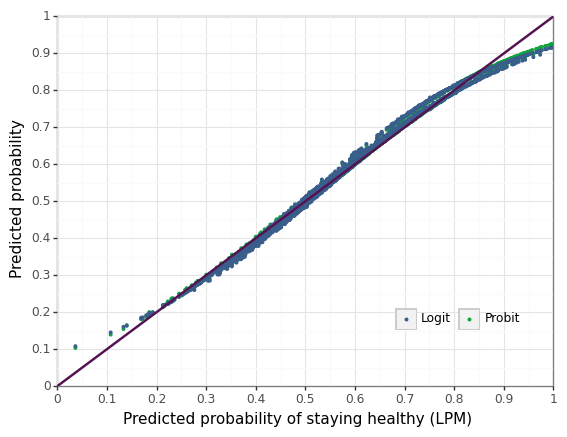

<ggplot: (684764913)>

In [71]:
g5 = (
    ggplot(df_plot, aes(x="pred_lpm", y="value", color="variable"))
    + geom_point(size=0.6)
    + geom_abline(color=color[2], intercept=0, slope=1, size=1)
    + labs(
        x="Predicted probability of staying healthy (LPM)", y="Predicted probability"
    )
    + scale_y_continuous(expand=[0.00, 0.0], limits=[0, 1], breaks=seq(0, 1.1, 0.1))
    + scale_x_continuous(expand=[0.00, 0.0], limits=[0, 1], breaks=seq(0, 1.1, 0.1))
    + scale_color_manual(values=[color[0], color[1]])
    + theme_bw()
    + theme(
        legend_title=element_blank(),
        legend_direction="horizontal",
        legend_position=(0.75, 0.25),
        legend_background=element_blank(),
    )
)
g5

# Part 5 goodness of fit

In [72]:
lpmbase = smf.ols("stayshealthy ~ smoking", data=share).fit()


In [73]:
share["pred_lpmbase"] = lpmbase.predict()


### Figure 11.7 Staying healthy and the distribution of the predicted probability of staying healthy. Two linear probability model

(a) Simple LPM

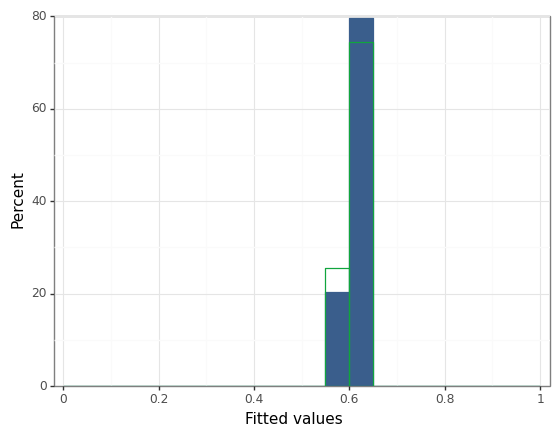

<ggplot: (687084421)>

In [74]:
(
    ggplot(
        share,
        aes(x="pred_lpmbase", fill="stayshealthy", y="stat(count/sum(count)))*100"),
    )
    + geom_histogram(
        share[share["stayshealthy"] == 1],
        binwidth=0.05,
        color=color[0],
        fill=color[0],
        boundary=0.55,
    )
    + geom_histogram(
        share[share["stayshealthy"] == 0],
        binwidth=0.05,
        color=color[1],
        fill=None,
        boundary=0.55,
    )
    + ylab("Percent")
    + xlab("Fitted values")
    + scale_x_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=seq(0, 1.1, 0.2))
    + scale_y_continuous(expand=[0.00, 0.00], limits=[0, 80], breaks=seq(0, 81, 20))
    + theme_bw()
)

(b) Rich LPM

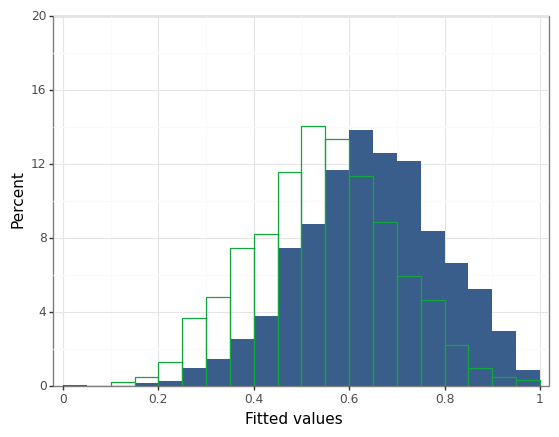

<ggplot: (684763215)>

In [75]:
g7b = (
    ggplot(
        share,
        aes(x="pred_lpm", fill="stayshealthy", y="stat(count/sum(count)))*100"),
    )
    + geom_histogram(
        share[share["stayshealthy"] == 1],
        binwidth=0.05,
        # color="blue",
        fill=color[0],
        boundary=0.55,
    )
    + geom_histogram(
        share[share["stayshealthy"] == 0],
        binwidth=0.05,
        color=color[1],
        fill=None,
        boundary=0.55,
    )
    + ylab("Percent")
    + xlab("Fitted values")
    + scale_x_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=seq(0, 1.1, 0.2))
    + scale_y_continuous(expand=[0.00, 0.00], limits=[0, 20], breaks=seq(0, 21, 4))
    + theme_bw()
)
g7b


#### Table 11.4 Comparing probability models – mean and median

In [76]:
share.groupby("stayshealthy")[
    "pred_lpmbase", "pred_lpm", "pred_logit", "pred_probit"
].mean().round(3)


,pred_lpmbase,pred_lpm,pred_logit,pred_probit
stayshealthy,,,,
0.0,0.603,0.543,0.542,0.542
1.0,0.606,0.645,0.646,0.646


In [77]:
share.groupby("stayshealthy")[
    "pred_lpmbase", "pred_lpm", "pred_logit", "pred_probit"
].median().round(3)


,pred_lpmbase,pred_lpm,pred_logit,pred_probit
stayshealthy,,,,
0.0,0.62,0.543,0.544,0.545
1.0,0.62,0.647,0.655,0.653


### Table 11.5 Statistics of goodness of fit for the probability predictions of three models

In [78]:
pd.DataFrame(
    {
        "R-squared": [
            lpm3.rsquared,
            r2_score(share["stayshealthy"], share["pred_logit"]),
            r2_score(share["stayshealthy"], share["pred_probit"]),
        ],
        "Brier-score": [
            mean_squared_error(share["stayshealthy"], share["pred_lpm"]),
            mean_squared_error(share["stayshealthy"], share["pred_logit"]),
            mean_squared_error(share["stayshealthy"], share["pred_probit"]),
        ],
        "Pseudo R-squared": [np.nan, logit_result.prsquared, probit_result.prsquared],
        "Log-loss": [
            -1 * log_loss(share["stayshealthy"], share["pred_lpm"]),
            -1 * log_loss(share["stayshealthy"], share["pred_logit"]),
            -1 * log_loss(share["stayshealthy"], share["pred_probit"]),
        ],
    },
    index=["LPM", "Logit", "Probit"],
).T.round(3)


,LPM,Logit,Probit
R-squared,0.103,0.104,0.104
Brier-score,0.215,0.214,0.214
Pseudo R-squared,NaN,0.080,0.080
Log-loss,-0.620,-0.617,-0.617


### Figure 11.8 Calibration curves for the predictions of the linear probability and logit models

(a) LPM

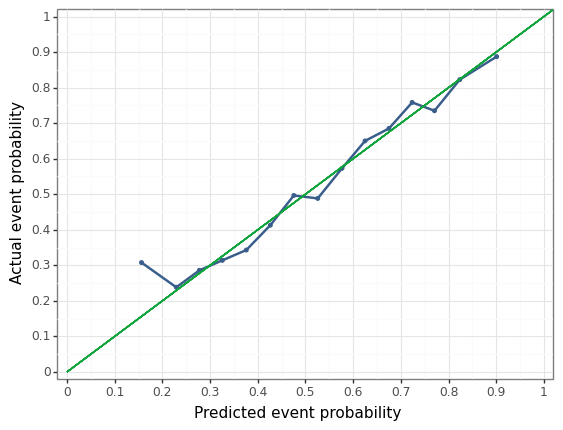

<ggplot: (674625922)>

In [79]:
create_calibration_plot(
    share,
    file_name="ch11-figure-8b-calib-logit",
    prob_var="pred_lpm",
    actual_var="stayshealthy",
    breaks=np.array(
        [
            0,
            0.2,
            0.25,
            0.3,
            0.35,
            0.4,
            0.45,
            0.5,
            0.55,
            0.6,
            0.65,
            0.7,
            0.75,
            0.8,
            0.85,
            1.05,
        ]
    ),
)


(b) Logit

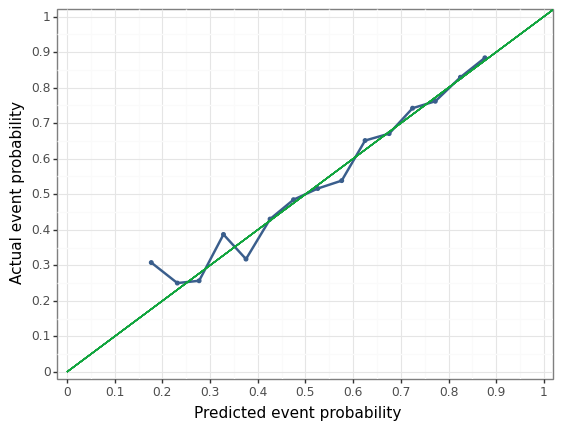

<ggplot: (687277294)>

In [80]:
create_calibration_plot(
    share,
    file_name="ch11-figure-8b-calib-logit",
    prob_var="pred_logit",
    actual_var="stayshealthy",
    breaks=np.array(
        [
            0,
            0.2,
            0.25,
            0.3,
            0.35,
            0.4,
            0.45,
            0.5,
            0.55,
            0.6,
            0.65,
            0.7,
            0.75,
            0.8,
            0.85,
            1.05,
        ]
    ),
)


In [81]:
## Part 7


In [82]:
df = share[["pred_lpmbase", "pred_lpm", "pred_logit", "pred_probit"]].copy()


In [83]:
for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        if df.iloc[i, j] > 0.5:
            df.iloc[i, j] = 1
        else:
            df.iloc[i, j] = 0


In [84]:
pd.crosstab(df.iloc[:, 0], share["stayshealthy"], normalize="all")


stayshealthy,0.0,1.0
pred_lpmbase,,
1.0,0.395304,0.604696


In [85]:
for j in range(df.shape[1]):
    print(pd.crosstab(df.iloc[:, j], share["stayshealthy"], normalize="all"))
    print(pd.crosstab(df.iloc[:, j], share["stayshealthy"], normalize="columns"))


stayshealthy       0.0       1.0
pred_lpmbase                    
1.0           0.395304  0.604696
stayshealthy  0.0  1.0
pred_lpmbase          
1.0           1.0  1.0
stayshealthy       0.0       1.0
pred_lpm                        
0.0           0.149244  0.100675
1.0           0.246060  0.504021
stayshealthy       0.0       1.0
pred_lpm                        
0.0           0.377543  0.166489
1.0           0.622457  0.833511
stayshealthy       0.0       1.0
pred_logit                      
0.0           0.153104  0.101962
1.0           0.242200  0.502734
stayshealthy       0.0       1.0
pred_logit                      
0.0           0.387307  0.168617
1.0           0.612693  0.831383
stayshealthy       0.0       1.0
pred_probit                     
0.0           0.150209  0.101640
1.0           0.245095  0.503056
stayshealthy       0.0       1.0
pred_probit                     
0.0           0.379984  0.168085
1.0           0.620016  0.831915


## Figure 11.4 The logit and probit link functions

In [86]:
share = pd.read_csv(os.path.join(data_out, "ch11_share.csv"))


In [87]:
share["country"] = share["country"].astype("category")


In [88]:
y, X = dmatrices(
    "stayshealthy ~ smoking + ever_smoked + female + age + lspline(eduyears,[8,18]) + \
                 income10 + lspline(bmi,[35]) + exerc + country",
    share,
)


In [89]:
logit = sm.Logit(y, X).fit()


Optimization terminated successfully.
         Current function value: 0.617166
         Iterations 5


In [90]:
logit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           stayshealthy   No. Observations:                 3109
Model:                          Logit   Df Residuals:                     3084
Method:                           MLE   Df Model:                           24
Date:                Thu, 06 Oct 2022   Pseudo R-squ.:                 0.08031
Time:                        15:48:16   Log-Likelihood:                -1918.8
converged:                       True   LL-Null:                       -2086.3
Covariance Type:            nonrobust   LLR p-value:                 1.329e-56
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         2.2781      0.885      2.573      0.010       0.543       4.013
country[T.12]                    -0.9828      0.330     -2.978      0.003      -1.630      -0.336
country[T.13]                    -0.1972      0.276     -0.714      0.475      -0.739       0.344
country[T.15]                    -0.6560      0.194     -3.382      0.001      -1.036      -0.276
country[T.16]                    -1.1196      0.185     -6.051      0.000      -1.482      -0.757
country[T.17]                    -0.7850      0.169     -4.640      0.000      -1.116      -0.453
country[T.18]                     0.4358      0.181      2.411      0.016       0.082       0.790
country[T.20]                     0.0679      0.159      0.426      0.670      -0.244       0.380
country[T.23]                    -0.5734      0.157     -3.650      0.000      -0.881      -0.265
country[T.28]                    -0.7552      0.176     -4.297      0.000      -1.100      -0.411
country[T.29]                    -1.4707      0.395     -3.719      0.000      -2.246      -0.696
country[T.33]                    -1.5783      0.301     -5.243      0.000      -2.168      -0.988
country[T.34]                    -0.9203      0.205     -4.482      0.000      -1.323      -0.518
country[T.35]                    -1.3535      0.211     -6.416      0.000      -1.767      -0.940
smoking                          -0.2840      0.109     -2.601      0.009      -0.498      -0.070
ever_smoked                       0.0782      0.092      0.849      0.396      -0.102       0.259
female                            0.1608      0.082      1.964      0.050       0.000       0.321
age                              -0.0123      0.014     -0.859      0.391      -0.040       0.016
lspline(eduyears, [8, 18])[0]    -0.0030      0.033     -0.090      0.928      -0.068       0.062
lspline(eduyears, [8, 18])[1]     0.0791      0.016      5.022      0.000       0.048       0.110
lspline(eduyears, [8, 18])[2]    -0.0457      0.055     -0.825      0.410      -0.154       0.063
income10                          0.0356      0.015      2.452      0.014       0.007       0.064
lspline(bmi, [35])[0]            -0.0575      0.011     -5.033      0.000      -0.080      -0.035
lspline(bmi, [35])[1]             0.0311      0.071      0.439      0.661      -0.108       0.170
exerc                             0.2548      0.079      3.229      0.001       0.100       0.410
=================================================================================================
"""

In [91]:
share["bx_logit"] = np.asarray(X).dot(logit.params)


In [92]:
share["Logit"] = logistic.cdf(share["bx_logit"])


In [93]:
probit = sm.Probit(y, X).fit()


Optimization terminated successfully.
         Current function value: 0.617255
         Iterations 5


In [94]:
probit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:           stayshealthy   No. Observations:                 3109
Model:                         Probit   Df Residuals:                     3084
Method:                           MLE   Df Model:                           24
Date:                Thu, 06 Oct 2022   Pseudo R-squ.:                 0.08018
Time:                        15:48:16   Log-Likelihood:                -1919.0
converged:                       True   LL-Null:                       -2086.3
Covariance Type:            nonrobust   LLR p-value:                 1.722e-56
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         1.4340      0.540      2.656      0.008       0.376       2.492
country[T.12]                    -0.5952      0.203     -2.926      0.003      -0.994      -0.197
country[T.13]                    -0.1128      0.166     -0.678      0.498      -0.439       0.213
country[T.15]                    -0.4007      0.119     -3.368      0.001      -0.634      -0.167
country[T.16]                    -0.6872      0.113     -6.082      0.000      -0.909      -0.466
country[T.17]                    -0.4761      0.103     -4.615      0.000      -0.678      -0.274
country[T.18]                     0.2573      0.105      2.440      0.015       0.051       0.464
country[T.20]                     0.0425      0.096      0.445      0.657      -0.145       0.230
country[T.23]                    -0.3450      0.095     -3.622      0.000      -0.532      -0.158
country[T.28]                    -0.4579      0.108     -4.252      0.000      -0.669      -0.247
country[T.29]                    -0.8784      0.235     -3.740      0.000      -1.339      -0.418
country[T.33]                    -0.9741      0.182     -5.359      0.000      -1.330      -0.618
country[T.34]                    -0.5592      0.126     -4.426      0.000      -0.807      -0.312
country[T.35]                    -0.8280      0.129     -6.407      0.000      -1.081      -0.575
smoking                          -0.1705      0.066     -2.568      0.010      -0.301      -0.040
ever_smoked                       0.0443      0.056      0.793      0.428      -0.065       0.154
female                            0.0973      0.050      1.953      0.051      -0.000       0.195
age                              -0.0083      0.009     -0.955      0.339      -0.025       0.009
lspline(eduyears, [8, 18])[0]    -0.0021      0.020     -0.102      0.918      -0.041       0.037
lspline(eduyears, [8, 18])[1]     0.0478      0.010      5.015      0.000       0.029       0.066
lspline(eduyears, [8, 18])[2]    -0.0286      0.033     -0.864      0.388      -0.093       0.036
income10                          0.0216      0.009      2.446      0.014       0.004       0.039
lspline(bmi, [35])[0]            -0.0346      0.007     -5.002      0.000      -0.048      -0.021
lspline(bmi, [35])[1]             0.0169      0.044      0.388      0.698      -0.069       0.102
exerc                             0.1510      0.048      3.148      0.002       0.057       0.245
=================================================================================================
"""

In [95]:
share["bx_probit"] = np.asarray(X).dot(probit.params)


In [96]:
share["Probit"] = norm.cdf(share["bx_probit"])


In [97]:
share_plot = pd.melt(
    share[["bx_logit", "Logit", "Probit"]],
    id_vars=["bx_logit"],
    value_vars=["Logit", "Probit"],
)


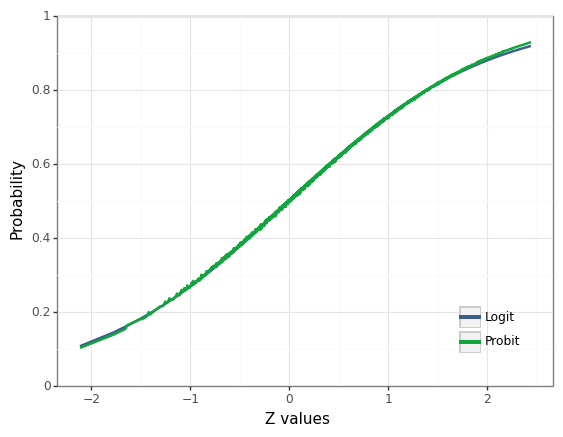

<ggplot: (687368593)>

In [98]:
g4 = (
    ggplot(data=share_plot)
    + geom_line(aes(x="bx_logit", y="value", color="variable"), size=1)
    + ylab("Probability")
    + xlab("Z values")
    + scale_color_manual(values=color[0:2], name=" ", labels=("Logit", "Probit"))
    + scale_y_continuous(expand=[0.00, 0.00], limits=[0, 1], breaks=seq(0, 1.1, 0.2))
    + theme_bw()
    + theme(
        legend_position=(0.8, 0.25),
        legend_direction="vertical",
        legend_background=element_blank(),
    )
)
g4